In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# Урок 4. Кейс 1. Построение и оценка модели.

**1.Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [59]:
data = pd.read_csv('./datasets/my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [60]:
data_week = data.resample('W').mean()

data_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


### Проверка данных на пропуски

In [61]:
data_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          866 non-null    float64
 1   year             866 non-null    float64
 2   month            866 non-null    float64
 3   dayofmonth       866 non-null    float64
 4   quarter          866 non-null    float64
 5   dayofyear        866 non-null    float64
 6   weekofyear       866 non-null    float64
 7   dayofweek        866 non-null    float64
 8   hour             866 non-null    float64
 9   is_holiday       866 non-null    float64
 10  is_prev_holiday  866 non-null    float64
 11  is_next_holiday  866 non-null    float64
dtypes: float64(12)
memory usage: 88.0 KB


In [62]:
# Проверка индексов на дубли
data_week[data_week.index.duplicated(keep=False)].size

0

In [63]:
# Проверка на пропуски в индексах
pd.date_range('2002-01-06', '2018-08-05', freq="W").size == data_week.index.size

True

In [64]:
# Проверка на пропуски в данных
data_week[data_week['PJME_MW'].isna()]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,


Данные не содержат пропусков и дублей. Удалим признаки дня недели `dayofweek` и часа `hour`, так как после ресэмплинга они потеряли актуальность. Так же удалим признак дня года `dayofyear`, так как он коррелируем с признаком недели года `weekofyear`. Так же в годовом развороте ряда тренда нет, значит признак `year` можно исключить.

In [65]:
# проверка корреляции признаков дня в году и недели в году
np.corrcoef(data_week['dayofyear'], data_week['weekofyear'])

array([[1.        , 0.99056974],
       [0.99056974, 1.        ]])

In [66]:
data_week.drop(['hour', 'dayofweek', 'dayofyear', 'year'], axis=1, inplace=True)
data_week.head()

,PJME_MW,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,1.0,0.160839,0.000000,0.167832
2002-01-13,31487.386905,1.000000,10.000000,1.0,2.0,0.000000,0.000000,0.000000
2002-01-20,31452.880952,1.000000,17.000000,1.0,3.0,0.000000,0.142857,0.000000
2002-01-27,30141.529762,1.000000,24.000000,1.0,4.0,0.142857,0.000000,0.142857
2002-02-03,29196.488095,1.428571,17.714286,1.0,5.0,0.000000,0.000000,0.000000


### Добавление новых признаков

Добавим в модель интегральный признак по кластер-анализу с использованием метода DBSCAN.

In [67]:
scl = StandardScaler()
tsne = TSNE(n_components=2, random_state=42)
clast = DBSCAN(eps=5, leaf_size=15)

In [68]:
X = data_week.drop('PJME_MW', axis=1).values
X_scale = scl.fit_transform(X)
X_t = tsne.fit_transform(X_scale)

In [69]:
X_clast = clast.fit_predict(X_t)

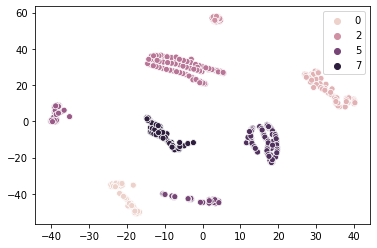

In [70]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [71]:
print('Число кластеров: ', len(np.unique(X_clast)))

Число кластеров:  8


Кластеризация с понижением размерности выглядит обоснованной. Добавим новый признак к данным.

In [72]:
data_week['clast'] = X_clast
data_week.head(10)

,PJME_MW,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,clast
Date,,,,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,1.0,0.160839,0.000000,0.167832,0
2002-01-13,31487.386905,1.000000,10.000000,1.0,2.0,0.000000,0.000000,0.000000,1
2002-01-20,31452.880952,1.000000,17.000000,1.0,3.0,0.000000,0.142857,0.000000,2
2002-01-27,30141.529762,1.000000,24.000000,1.0,4.0,0.142857,0.000000,0.142857,0
2002-02-03,29196.488095,1.428571,17.714286,1.0,5.0,0.000000,0.000000,0.000000,1
2002-02-10,31150.517857,2.000000,7.000000,1.0,6.0,0.000000,0.000000,0.000000,1
2002-02-17,30616.565476,2.000000,14.000000,1.0,7.0,0.000000,0.142857,0.000000,2
2002-02-24,29144.130952,2.000000,21.000000,1.0,8.0,0.142857,0.000000,0.142857,0
2002-03-03,29869.011905,2.428571,16.000000,1.0,9.0,0.000000,0.000000,0.000000,1


Добавим ещё два признака, построенных с помощью метода главных компонент.

In [73]:
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X_scale)

In [74]:
data_week['pca1'] = X_pca[:,0]
data_week['pca2'] = X_pca[:,1]

Добавим в модель признак нормированной первой разности.

In [75]:
data_week['diff1_norm'] = data_week['PJME_MW'].diff(1).fillna(0) / data_week['PJME_MW']

Добавим признак скользящего среднего с шириной окна в 12 месяцев. Этот период выбран как годичный цикл.

In [76]:
window_size = 12
data_week[f'window_{window_size}'] = data_week['PJME_MW'].rolling(window=window_size).mean()
data_week.tail()

,PJME_MW,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,clast,pca1,pca2,diff1_norm,window_12
Date,,,,,,,,,,,,,
2018-07-08,38459.982143,7.000000,5.000000,3.0,27.0,0.142857,0.142857,0.142857,5,1.466760,3.057772,0.066254,30440.186012
2018-07-15,36420.035714,7.000000,12.000000,3.0,28.0,0.000000,0.000000,0.000000,6,0.123204,-0.894238,-0.056012,31161.817460
2018-07-22,35612.095238,7.000000,19.000000,3.0,29.0,0.000000,0.000000,0.000000,6,0.198536,-0.893887,-0.022687,31999.494544
2018-07-29,36581.821429,7.000000,26.000000,3.0,30.0,0.000000,0.000000,0.000000,6,0.273869,-0.893535,0.026508,32702.313492
2018-08-05,36568.804124,7.505155,15.865979,3.0,31.0,0.000000,0.000000,0.000000,6,0.335486,-0.952463,-0.000356,33531.704907


Добавим несколько значений экспоненциальных средних.

In [77]:
# экспоненциальное сглаживание

def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

In [78]:
data_week['exp_0_01'] = exponential_smoothing(data_week['PJME_MW'], 0.01)
data_week['exp_0_03'] = exponential_smoothing(data_week['PJME_MW'], 0.03)
data_week['exp_0_08'] = exponential_smoothing(data_week['PJME_MW'], 0.08)

data_week.tail()

,PJME_MW,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,clast,pca1,pca2,diff1_norm,window_12,exp_0_01,exp_0_03,exp_0_08
Date,,,,,,,,,,,,,,,,
2018-07-08,38459.982143,7.000000,5.000000,3.0,27.0,0.142857,0.142857,0.142857,5,1.466760,3.057772,0.066254,30440.186012,31149.351351,30974.370915,31223.895665
2018-07-15,36420.035714,7.000000,12.000000,3.0,28.0,0.000000,0.000000,0.000000,6,0.123204,-0.894238,-0.056012,31161.817460,31202.058195,31137.740859,31639.586869
2018-07-22,35612.095238,7.000000,19.000000,3.0,29.0,0.000000,0.000000,0.000000,6,0.198536,-0.893887,-0.022687,31999.494544,31246.158565,31271.971490,31957.387539
2018-07-29,36581.821429,7.000000,26.000000,3.0,30.0,0.000000,0.000000,0.000000,6,0.273869,-0.893535,0.026508,32702.313492,31299.515194,31431.266988,32327.342250
2018-08-05,36568.804124,7.505155,15.865979,3.0,31.0,0.000000,0.000000,0.000000,6,0.335486,-0.952463,-0.000356,33531.704907,31352.208083,31585.393102,32666.659200


Добавим истории длиной p = 12 по основному признаку `PJME_MW` и по признаку первых разностей `diff1_norm`. 

In [79]:
p = 12

for i in range(p):
    offset = i + 1
    data_week[f't_{offset}'] = 0
    data_week[f't_{offset}'][offset:] = data_week['PJME_MW'][:-offset]


for i in range(p):
    offset = i + 1
    data_week[f'd_{offset}'] = 0
    data_week[f'd_{offset}'][offset:] = data_week['diff1_norm'][:-offset]

In [80]:
data_week.columns

Index(['PJME_MW', 'month', 'dayofmonth', 'quarter', 'weekofyear', 'is_holiday',
       'is_prev_holiday', 'is_next_holiday', 'clast', 'pca1', 'pca2',
       'diff1_norm', 'window_12', 'exp_0_01', 'exp_0_03', 'exp_0_08', 't_1',
       't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11',
       't_12', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9',
       'd_10', 'd_11', 'd_12'],
      dtype='object')

In [81]:
data_week.shape

(866, 40)

In [82]:
data_week.head(20)

,PJME_MW,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,clast,pca1,...,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,1.0,0.160839,0.000000,0.167832,0,-1.713693,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-13,31487.386905,1.000000,10.000000,1.0,2.0,0.000000,0.000000,0.000000,1,-2.797300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,1.000000,17.000000,1.0,3.0,0.000000,0.142857,0.000000,2,-2.308051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-27,30141.529762,1.000000,24.000000,1.0,4.0,0.142857,0.000000,0.142857,0,-1.641663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-03,29196.488095,1.428571,17.714286,1.0,5.0,0.000000,0.000000,0.000000,1,-2.575968,...,-0.028734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-10,31150.517857,2.000000,7.000000,1.0,6.0,0.000000,0.000000,0.000000,1,-2.506855,...,-0.001097,-0.028734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-17,30616.565476,2.000000,14.000000,1.0,7.0,0.000000,0.142857,0.000000,2,-2.017606,...,-0.043506,-0.001097,-0.028734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-24,29144.130952,2.000000,21.000000,1.0,8.0,0.142857,0.000000,0.142857,0,-1.351218,...,-0.032368,-0.043506,-0.001097,-0.028734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-03-03,29869.011905,2.428571,16.000000,1.0,9.0,0.000000,0.000000,0.000000,1,-2.278357,...,0.062729,-0.032368,-0.043506,-0.001097,-0.028734,0.000000,0.000000,0.000000,0.000000,0.000000


В итоге получили 40 признаков. Из-за того что мы брали историю первых разностей глубины 12, и первого значения первой разности у нас не было, при построении модели нужно будет исключить из анализа 13 первых наблюдений.

### Выделение существенных признаков

In [83]:
# глубина предсказания
h = 1

# скэлер целевого признака
scaler_y = StandardScaler()

# целевой признак
y_ = data_week['PJME_MW'].values[h+p+1:].reshape((data_week.shape[0]-h-p-1, 1))

# скалированный целевой признак
y = scaler_y.fit_transform(y_)

y.shape

(852, 1)

In [84]:
# скэлер поля признаков
scaler_x = StandardScaler()

# поле признаков
X_ = data_week.iloc[p+1:-h,:].values

# скалированное поле признаков
X = scaler_x.fit_transform(X_)

X.shape

(852, 40)

Размеры признаков совпали. Применим механизмы селекции признаков для нашей модели SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel.

In [85]:
# k лучших признаков

sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X, y.ravel())

data_week.columns[sfk.get_support()]

Index(['PJME_MW', 't_1', 't_2', 't_11', 't_12'], dtype='object')

In [86]:
# признаки по заданному проценту точности

sfp = SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

data_week.columns[sfp.get_support()]

Index(['PJME_MW', 't_1', 't_2', 't_12'], dtype='object')

In [87]:
# выбор признаков из коробочной модели с оценкой значимости признаков

gr_model = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

sfm = SelectFromModel(gr_model, max_features=5)
X_new3 = sfm.fit_transform(X, y.ravel())

data_week.columns[sfm.get_support()]

Index(['PJME_MW', 't_8', 't_11'], dtype='object')

In [88]:
# важность признаков модели градиентного бустинга
sfm.estimator_.feature_importances_

array([6.28774816e-01, 9.70314966e-03, 6.13198186e-03, 2.70627719e-04,
       1.76768185e-02, 3.60431690e-05, 6.04394096e-04, 8.97892634e-05,
       7.47879558e-03, 1.23590571e-02, 8.62743193e-03, 7.46662366e-03,
       1.03654520e-02, 1.78123420e-02, 1.23204430e-02, 5.66599703e-03,
       2.10756589e-02, 1.00179140e-02, 1.06467447e-02, 1.19691299e-02,
       6.21920884e-03, 3.03169058e-03, 9.22147307e-03, 2.85440545e-02,
       1.83208093e-02, 8.24134224e-03, 3.00304099e-02, 5.19125094e-03,
       5.88956718e-03, 1.46037123e-02, 4.39573341e-03, 8.57737159e-03,
       4.36975281e-03, 8.31470704e-03, 7.80153073e-03, 8.83540608e-03,
       9.32073278e-03, 6.03653331e-03, 7.51599599e-03, 6.44550688e-03])

In [89]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 16 17 26 27]
Номера признаков лучших признаков по процентной форме:  [ 0 16 17 27]
Номера признаков для выбора по модели :  [ 0 23 26]


Выберем для анализа совокупность признаков, отобранным по всем трём методам.

In [90]:
feature_list = [0, 16, 17, 23, 26, 27]
data_week.columns[feature_list]

Index(['PJME_MW', 't_1', 't_2', 't_8', 't_11', 't_12'], dtype='object')

Создадим итоговые скэлеры по существенным признакам

In [91]:
scaler_y = StandardScaler()
scaler_y.fit(data_week['PJME_MW'].values.reshape((data_week.shape[0], 1)))

scaler_x = StandardScaler()
scaler_x.fit(data_week.iloc[:,feature_list].values)

StandardScaler()

### Разделеине данных на тестовые и тренировочные

In [92]:
# разбиение на тестовую и тренировочную выборку 
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

В нашем датасэте есть данные с 2002-01-06 по 2018-08-05. В качестве границы выберем 2016-01-01.

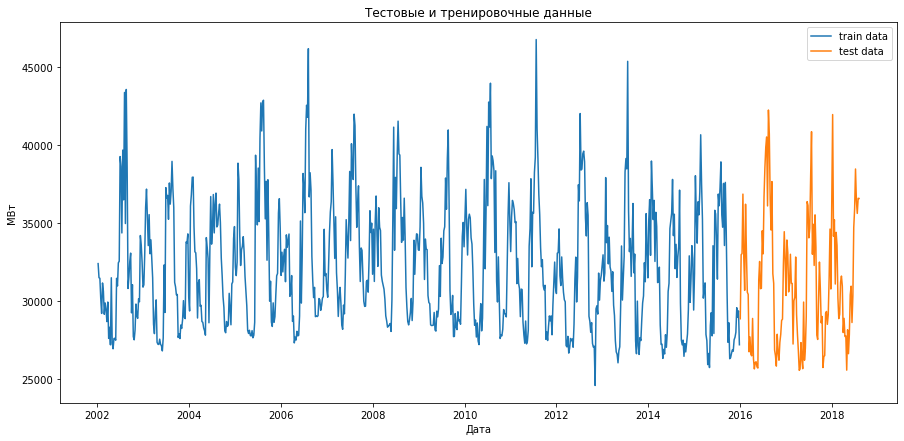

In [93]:
train, test = split_data(data_week, '01-01-2016')

plt.figure( figsize=(15, 7))
plt.plot(train.index, train['PJME_MW'], label='train data' )
plt.plot(test.index, test['PJME_MW'], label='test data')

plt.xlabel('Дата')
plt.ylabel('МВт')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

### Метрики качества

In [94]:
# средняя процентная ошибка

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [95]:
# вывод ошибок на экран

def calc_errors(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred) 
    mae = mean_absolute_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f'\tmse:\t{mse}\n\tmae:\t{mae}\n\tr2:\t{r2}\n\tmape:\t{mape}')

**2.Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [96]:
h = 4

X = data_week.iloc[p+1:-h, feature_list]
y = data_week['PJME_MW'].values[h+p+1:].reshape((data_week.shape[0]-h-p-1, 1))

train, test = split_data(X, '01-01-2016')

X_train = scaler_x.transform(train.values)
X_test = scaler_x.transform(test.values)
y_train = scaler_y.transform(y[:train.shape[0]])
y_test = scaler_y.transform(y[-test.shape[0]:])

In [108]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f'Model with rank: {i}')
            print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]
            ))
            print('Parameters: {0}\n'.format(results['params'][candidate]))

In [113]:
param_dist = {
    "max_depth": [2, 3, 5, 10, 15], 
    "n_estimators": [100, 200, 300, 400, 500, 1000, 1200, 1500]
}

model_gr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=10, cv=5, iid=False, random_state=42)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.630 (std: 0.059)
Parameters: {'n_estimators': 100, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.605 (std: 0.067)
Parameters: {'n_estimators': 500, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.604 (std: 0.059)
Parameters: {'n_estimators': 400, 'max_depth': 5}



In [114]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [115]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [116]:
print('Ошибка на тренировочной выборке:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred))

print('Ошибка на тестовой выборке:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred))

Ошибка на тренировочной выборке:
	mse:	614726.3050072811
	mae:	606.523109182599
	r2:	0.9608409479108269
	mape:	13.294265796895235
Ошибка на тестовой выборке:
	mse:	7768717.687860702
	mae:	2303.876725014926
	r2:	0.5315976050471257
	mape:	14.041576723280654


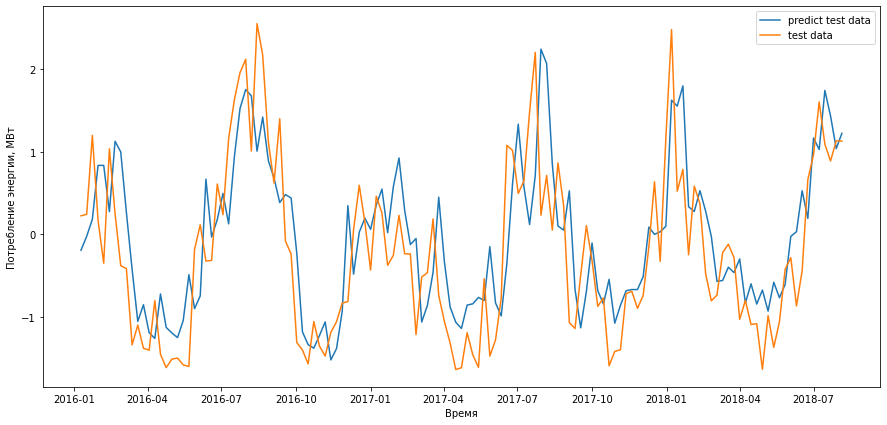

In [117]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(data_week.index[-len(y_test):], y_test_pred, label='predict test data' )
plt.plot(data_week.index[-len(y_test):], y_test, label='test data')

plt.legend()
plt.show()

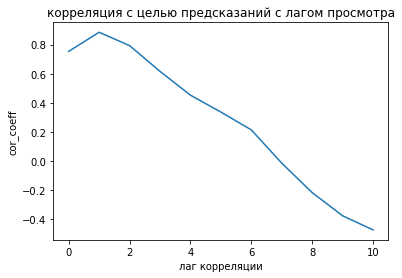

In [131]:
lag=10

cor = [np.corrcoef(y_test.ravel(), y_test_pred)[1,0]]

for i in range(lag):
    cor.append(np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred[(i+1):])[1,0])

plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')

plt.plot(np.arange(lag+1), np.array(p_cor_g))

plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

**3.Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [123]:
h = 1

X = data_week.iloc[p+1:-h, feature_list]
y = data_week['PJME_MW'].values[h+p+1:].reshape((data_week.shape[0]-h-p-1, 1))

train, test = split_data(X, '01-01-2016')

X_train = scaler_x.transform(train.values)
X_test = scaler_x.transform(test.values)
y_train = scaler_y.transform(y[:train.shape[0]])
y_test = scaler_y.transform(y[-test.shape[0]:])

In [124]:
param_dist = {
    "max_depth": [2, 3, 5, 10, 15], 
    "n_estimators": [100, 200, 300, 400, 500, 1000, 1200, 1500]
}

model_gr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=10, cv=5, iid=False, random_state=42)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.630 (std: 0.059)
Parameters: {'n_estimators': 100, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.605 (std: 0.067)
Parameters: {'n_estimators': 500, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.604 (std: 0.059)
Parameters: {'n_estimators': 400, 'max_depth': 5}



In [125]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [126]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [127]:
print('Ошибка на тренировочной выборке:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred))

print('Ошибка на тестовой выборке:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred))

Ошибка на тренировочной выборке:
	mse:	614726.3050072811
	mae:	606.523109182599
	r2:	0.9608409479108269
	mape:	13.294265796895235
Ошибка на тестовой выборке:
	mse:	7768717.687860702
	mae:	2303.876725014926
	r2:	0.5315976050471257
	mape:	14.041576723280654


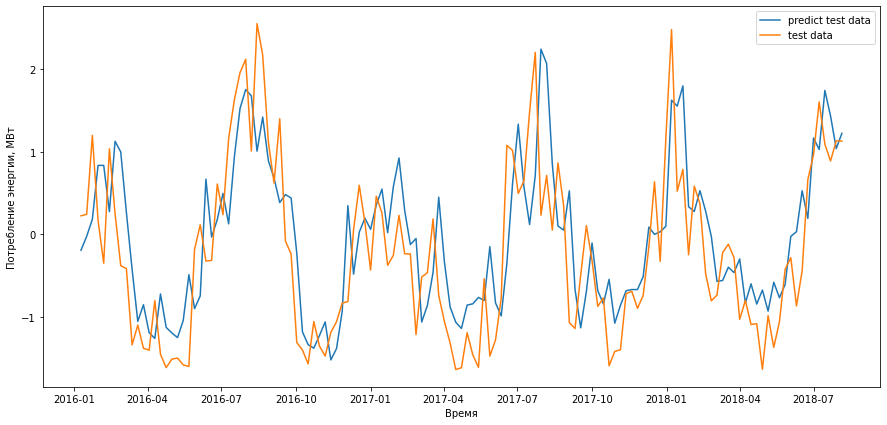

In [128]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(data_week.index[-len(y_test):], y_test_pred, label='predict test data')
plt.plot(data_week.index[-len(y_test):], y_test, label='test data')

plt.legend()
plt.show()

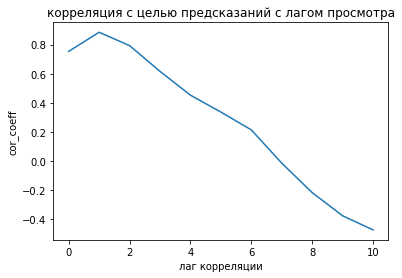

In [130]:
lag=10

cor = [np.corrcoef(y_test.ravel(), y_test_pred)[1,0]]

for i in range(lag):
    cor.append(np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred[(i+1):])[1,0])

plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')

plt.plot(np.arange(lag+1), np.array(p_cor_g))

plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

**4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [186]:
data_week.columns[feature_list]

Index(['PJME_MW', 't_1', 't_2', 't_8', 't_11', 't_12'], dtype='object')

In [227]:
X_text_recursive = X_test.copy()
y_test_recursive = y_test.copy()

for i_ in range(0, y_test.shape[0]-p):
    i = i_ + p

    y_test_recursive[i] = model.predict(X_text_recursive[i,:].reshape((1, X_text_recursive.shape[1])))

    # восстанавливаем не масштабированное значение ряда текущей точке 
    y_i = scaler_y.inverse_transform(y_test_recursive[i])
                                     
    # заполняем вектор для прогноза следующей точки
    if i + 1 < y_test.shape[0]:
        # PJME_MW
        X_text_recursive[i+1, 0] = (y_i - scaler_x.mean_[0]) / scaler_x.scale_[0]
        # t_1
        X_text_recursive[i+1, 1] = X_text_recursive[i-1, 0]
        # t_2
        X_text_recursive[i+1, 2] = X_text_recursive[i-2, 0]
        # t_8
        X_text_recursive[i+1, 3] = X_text_recursive[i-8, 0]
        # t_11
        X_text_recursive[i+1, 4] = X_text_recursive[i-11, 0]
        # t_12
        X_text_recursive[i+1, 5] = X_text_recursive[i-12, 0]

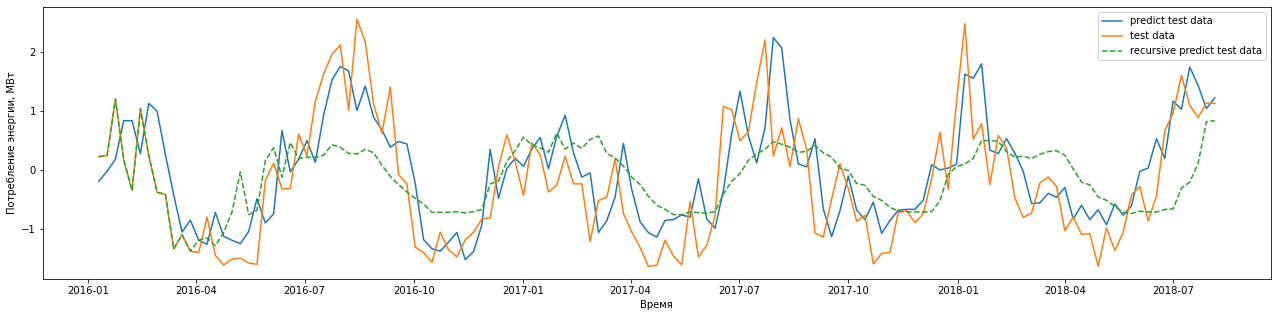

In [233]:
plt.figure(figsize=(22, 5))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(data_week.index[-len(y_test):], y_test_pred, label='predict test data')
plt.plot(data_week.index[-len(y_test):], y_test, label='test data')
plt.plot(data_week.index[-len(y_test):], y_test_recursive, '--', label='recursive predict test data')

plt.legend()
plt.show()

In [231]:
print('Ошибка на тестовой выборке при рекурсивном прогнозировании:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_recursive))

Ошибка на тренировочной выборке при рекурсивном прогнозировании:
	mse:	10968396.301417468
	mae:	2560.5863030636838
	r2:	0.3386781058598417
	mape:	8.192398738662494


При рекурсивном прогнозировании на одну неделю вперёд ошибка MAPE составила $8.19\%$. При обычном прогнозировании $14.04\%$.

**5.Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте усреденение по десяткам точек).**

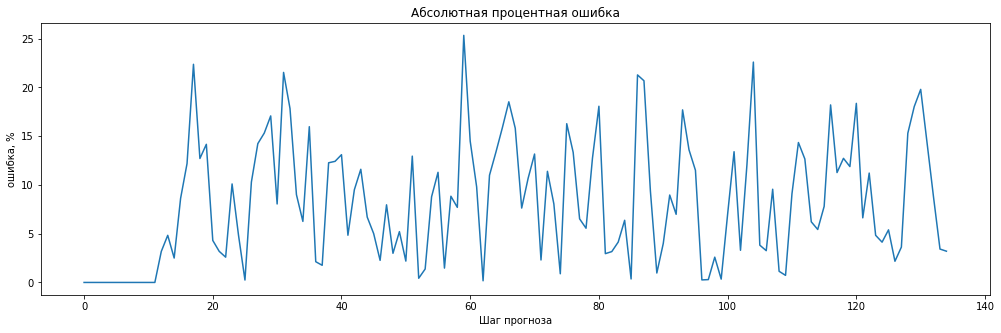

In [271]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_test_recursive_unscaled = scaler_y.inverse_transform(y_test_recursive)

errors = np.abs((y_test_unscaled - y_test_recursive_unscaled) / y_test_unscaled).ravel() * 100

plt.figure(figsize=(17, 5))

plt.plot(errors)
plt.title('Абсолютная процентная ошибка')
plt.xlabel('Шаг прогноза')
plt.ylabel('ошибка, %')
plt.show()

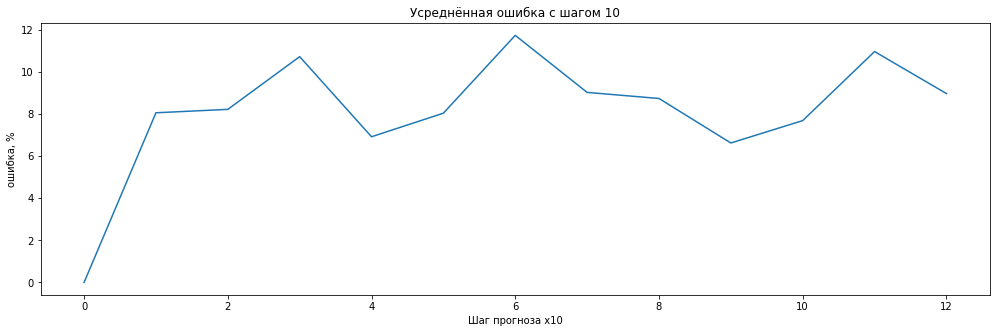

In [272]:
window = 10
errors_window = [errors[i*window:(i+1)*window].mean() for i in range(int(y_test.shape[0] / window))]

plt.figure(figsize=(17, 5))

plt.plot(errors_window)
plt.title(f'Усреднённая ошибка с шагом {window}')
plt.xlabel(f'Шаг прогноза x{window}')
plt.ylabel('ошибка, %')
plt.show()

**6.Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.**

В при горизонте прогнозирования до глубины истории в данных, по которым строится прогноз для следующей точки, находится информация об истинном значении целевой переменной. Поэтому сперва ошибка не сильно отличается от обычного прогноза с шагом 1. Далее график рекурсивного прогноза становится более однородным и ошибка колеблется вокруг одного значения. В нашем эксперименте получилось что при рекурсивном прогнозе на 1 шаг ошибка составила $8.19\%$. При обычном прогнозировании $14.04\%$. В теории должно было получиться наоборот.